In [23]:
import pandas as pd
from collections import Counter
import nltk
from nltk.corpus import stopwords
import numpy as np

In [24]:
df=pd.read_csv('edmunds.csv')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [25]:
stop = stopwords.words('english')
def remove_stopwords(text):
    words = nltk.word_tokenize(text)
    stop_words = set(stopwords.words("english"))
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words)
df['body']=df['body'].str.lower()

df['body'] = df['body'].astype(str).apply(remove_stopwords)
print(df['body'])

0        `` bottom line think throw blanket cars terms ...
1        legacy gt another one 'm looking forward . 'd ...
2        `` g35 , tl & is300 worshipers gon na upset ne...
3        review mag articles relate specifically gt , m...
4        buy srt4 cheap , put $ 10k worth mods blow eve...
                               ...                        
17496    far know , , 3 series , infiniti g35 , acura t...
17497    honestly , good reasons might choose tl g35 , ...
17498    going include mazda stop , bring hyundai azera...
17499    know , described lesson learnt hard way . boug...
17500    `` . . .a base 328i . . .that miserable base e...
Name: body, Length: 17501, dtype: object


In [26]:
# Map the brand names to the car names
mapping_df = pd.read_csv('car_models_and_brands.csv')
model_to_brand = dict(zip(mapping_df['Model'], mapping_df['Brand']))
def replace_model_with_brand(comment):
    for model, brand in model_to_brand.items():
        comment = comment.replace(model, brand)
    return comment

df['body'] = df['body'].str.lower().apply(replace_model_with_brand)

In [27]:
brands=mapping_df['Brand'].unique()
values_to_remove = ['car', 'seat', 'problem','"hyundai,"','hyundai.','"kia,"','kia.','sedan']

brands = [x for x in brands if x not in values_to_remove]

In [28]:
brand_freq = {}

# Iterate through the "body" column of the target DataFrame
for _, row in df.iterrows():
    body_text = row['body']
    # Check for NaN values and skip them
    if not isinstance(body_text, str) and np.isnan(body_text):
        continue
    
    # Split the "body" text into words
    words = body_text.split()

    words = list(set(words))

    # Count the frequency of brand names in the "body" text
    for word in words:
        if word in brands:
            brand_freq[word] = brand_freq.get(word, 0) + 1

# Now, brand_freq dictionary contains the frequency counts of brand names in the "body" column
print(brand_freq)

{'infiniti': 1234, 'acura': 1699, 'bmw': 5702, 'honda': 1374, 'subaru': 543, 'audi': 1531, 'ford': 512, 'dodge': 218, 'toyota': 1154, 'volkswagen': 543, 'nissan': 776, 'mitsubishi': 75, 'mercedes-benz': 780, 'volvo': 577, 'hyundai': 352, 'chevrolet': 364, 'cadillac': 545, 'saturn': 48, 'chrysler': 180, 'mazda': 284, 'pontiac': 185, 'lincoln': 430, 'kia': 68, 'suzuki': 48, 'buick': 172, 'mercury': 21}


In [29]:
sorted_dict = sorted(brand_freq.items(), key=lambda item: item[1],reverse=True)
top_10_brands=sorted_dict[:10]
for brand, frequency in top_10_brands:
    print(f'{brand}: {frequency}')
top_10_list = [item[0] for item in top_10_brands]

bmw: 5702
acura: 1699
audi: 1531
honda: 1374
infiniti: 1234
toyota: 1154
mercedes-benz: 780
nissan: 776
volvo: 577
cadillac: 545


In [30]:
# Initialize a dictionary to store brand mentions per post
brand_mentions_per_post = {brand: set() for brand in top_10_list}

# Initialize dictionaries to store brand co-mentions and individual brand mentions
co_mentions = {}
for brand1 in top_10_list:
    co_mentions[brand1] = {}
    for brand2 in top_10_list:
        co_mentions[brand1][brand2] = 0
individual_mentions = {brand: 0 for brand in top_10_list}

# Function to calculate lift ratio between two brands
def calculate_lift(brand1, brand2, total_posts):
    if brand1 == brand2:
        return 0  # Lift ratio between the same brand is 0
    # Calculate lift using the formula: lift(brand1, brand2) = (P(brand1 and brand2) / (P(brand1) * P(brand2))) * N
    p_brand1_and_brand2 = co_mentions[brand1][brand2]
    p_brand1 = individual_mentions[brand1]
    p_brand2 = individual_mentions[brand2]
    if p_brand1 == 0 or p_brand2 == 0:
        return 0  
    else:
        return (p_brand1_and_brand2 / (p_brand1 * p_brand2)) * total_posts

# Iterate through the "body" column of the target DataFrame
for _, row in df.iterrows():
    body_text = row['body']
    
    # Check for NaN values and skip them
    if not isinstance(body_text, str) and np.isnan(body_text):
        continue
    
    # Split the "body" text into words
    words = body_text.split()
    
    # Convert words to lowercase for case-insensitive matching
    words = [word.lower() for word in words]
    
    # Keep track of previously mentioned brands in the current post
    mentioned_brands_in_post = set()
    co_brands_in_post= set()
    
    for i, word in enumerate(words):
        if word in top_10_list:
            # Check if the brand was already mentioned in the current post
            if word not in mentioned_brands_in_post:
                # Increment individual mention count for the brand
                individual_mentions[word] += 1
                # Update the set of mentioned brands in the current post
                mentioned_brands_in_post.add(word)
                
                # Check for co-mentions of other brands in the same post
                for j in range(i + 1, min(i + 7, len(words))):  # Change '6' to your desired separation limit
                    if words[j] in top_10_list:
                        # Increment co-mention count for the pair of brands (both directions)
                        co_mentions[word][words[j]] += 1
                        co_mentions[words[j]][word] += 1  # Symmetric update
            elif word not in co_brands_in_post:
                for j in range(i + 1, min(i + 7, len(words))):  # Change '6' to your desired separation limit
                    if words[j] in top_10_list:
                        # Increment co-mention count for the pair of brands (both directions)
                        co_mentions[word][words[j]] += 1
                        co_mentions[words[j]][word] += 1

# Calculate total number of posts
total_posts = len(df)

lift_ratios = {}
lift_already_calculated = set()  # To keep track of already calculated lift pairs

for brand1 in top_10_list:
    for brand2 in top_10_list:
        if brand1 != brand2:
            # Ensure we calculate lift only once for each pair (ignoring the order)
            pair = tuple(sorted([brand1, brand2]))
            if pair not in lift_already_calculated:
                lift_ratio = calculate_lift(brand1, brand2, total_posts)
                lift_ratios[pair] = lift_ratio
                lift_already_calculated.add(pair)

# Sort lift ratios in descending order
sorted_lift_ratios = sorted(lift_ratios.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 unique lift ratios and associated brand pairs
for (brand1, brand2), lift_ratio in sorted_lift_ratios[:50]:
    print(f'Lift({brand1}, {brand2}) = {lift_ratio:.2f}')


Lift(mercedes-benz, volvo) = 4.63
Lift(honda, toyota) = 4.16
Lift(audi, volvo) = 4.04
Lift(nissan, toyota) = 3.17
Lift(honda, nissan) = 2.89
Lift(cadillac, mercedes-benz) = 2.68
Lift(acura, infiniti) = 2.66
Lift(audi, mercedes-benz) = 2.29
Lift(audi, cadillac) = 2.18
Lift(acura, audi) = 1.77
Lift(audi, infiniti) = 1.66
Lift(acura, honda) = 1.63
Lift(cadillac, infiniti) = 1.56
Lift(acura, cadillac) = 1.44
Lift(bmw, mercedes-benz) = 1.30
Lift(audi, bmw) = 1.25
Lift(acura, volvo) = 1.05
Lift(bmw, infiniti) = 1.05
Lift(bmw, cadillac) = 1.04
Lift(honda, volvo) = 0.93
Lift(infiniti, volvo) = 0.86
Lift(infiniti, mercedes-benz) = 0.84
Lift(acura, mercedes-benz) = 0.81
Lift(acura, bmw) = 0.75
Lift(infiniti, nissan) = 0.75
Lift(nissan, volvo) = 0.70
Lift(cadillac, volvo) = 0.67
Lift(acura, nissan) = 0.57
Lift(bmw, volvo) = 0.54
Lift(honda, infiniti) = 0.50
Lift(honda, mercedes-benz) = 0.47
Lift(toyota, volvo) = 0.42
Lift(mercedes-benz, toyota) = 0.39
Lift(bmw, honda) = 0.38
Lift(bmw, toyota) = 0

In [31]:
sorted_lift_ratios[44][0]

('mercedes-benz', 'nissan')

In [32]:
# Create a new tuple with the desired changes
# updated_tuple = (sorted_lift_ratios[44][0], 0.1)
# # updated_tuple = sorted_lift_ratios[44][0]


# # Create a new list with the updated tuple
# sorted_lift_ratios = sorted_lift_ratios[:44] + [updated_tuple] + sorted_lift_ratios[44 + 1:]



#sorted_lift_ratios[44][1]=0.001

c:\Users\rahul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


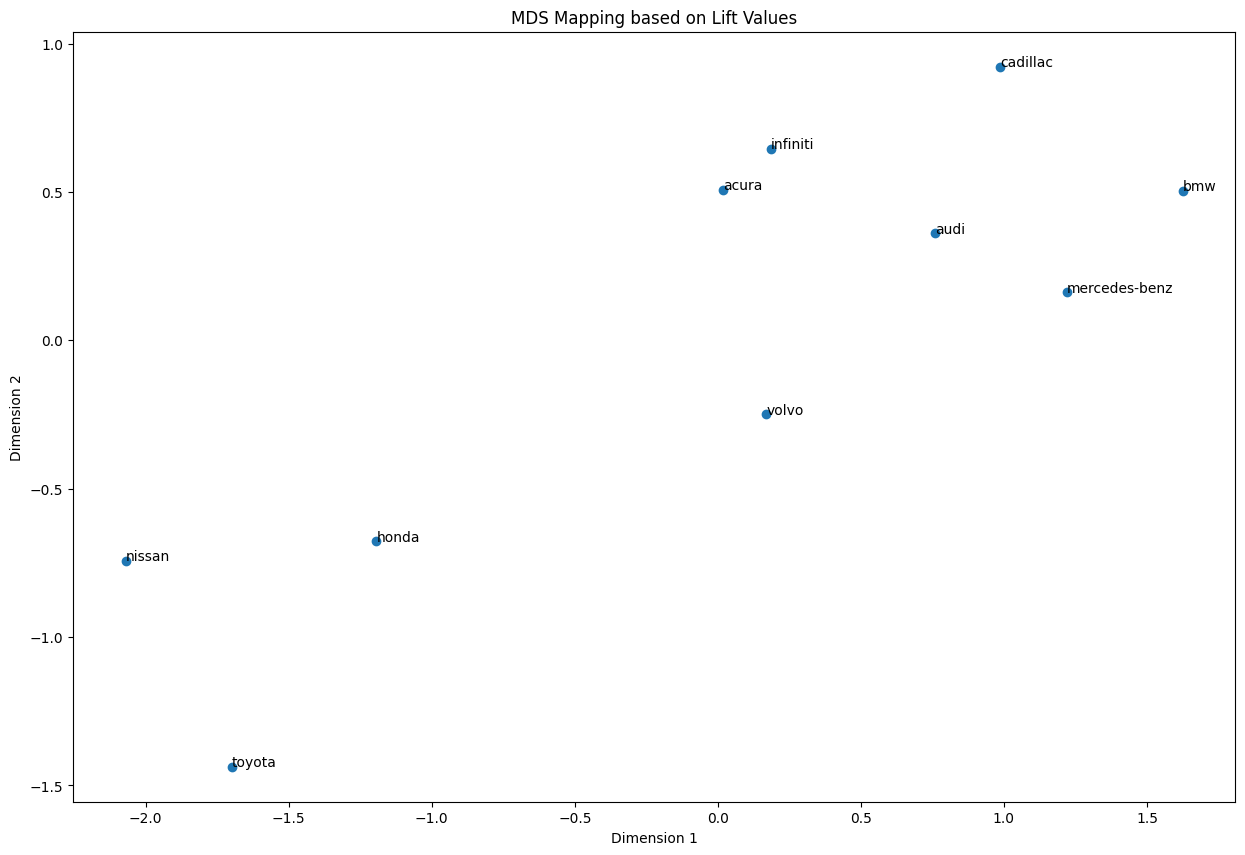

In [33]:
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Extract the unique brand names
brands = set()
for lift_item, _ in sorted_lift_ratios:
    brands.update(lift_item)
brands = list(brands)

# Create an empty dissimilarity matrix
n = len(brands)
dissimilarity_matrix = np.zeros((n, n))

# Fill the dissimilarity matrix with lift values
for i in range(n):
    for j in range(n):
        if i != j:
            brand_pair = (brands[i], brands[j])
            # Find the lift value for the brand pair
            for lift_item, lift_value in sorted_lift_ratios:
                if brand_pair == lift_item or brand_pair == lift_item[::-1]:
                    dissimilarity_matrix[i, j] = 1 / lift_value  # You may need to adjust this scaling
                    break

# Initialize the MDS model
mds = MDS(n_components=2, dissimilarity="precomputed")

# Fit the data and perform MDS mapping
mds_result = mds.fit_transform(dissimilarity_matrix)

# Plot the MDS results with labels
plt.figure(figsize=(15, 10))
plt.scatter(mds_result[:, 0], mds_result[:, 1])
for i, brand in enumerate(brands):
    plt.annotate(brand, (mds_result[i, 0], mds_result[i, 1]))
plt.title("MDS Mapping based on Lift Values")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()
